# Constrained statistical learning plus experimental data predicts the functional effect of mutations in a model enzyme 



## Rosetta models of each mutation in our data set 

First, we'll make models of all of the enzymes using Rosetta. All we need is a wild type PDB structure, `bglb.pdb`, and a list of mutations that we have kinetic data for, `mutant_list`. 

In [10]:
! ls data_sets/

distance_from_active_site.csv  expression_data.csv	   scorefile.csv
enzyme_design_features.csv     expression_spring_2016.csv
expression_cat.csv	       raw_thermo_data.csv


In [5]:
# this one for MutateResidue 

from Bio.SeqUtils import IUPACData
nstruct = 100

with open( 'mutant_list' ) as fn:
    mutants = [ i.strip() for i in fn.readlines() if len( i ) > 1 ] 
    print len( mutants ), 'mutants'

nstruct = 100

runs = [
    '-parser:script_vars target={} new_res={} -suffix _{}_{:04d}\n'.format( 
        m[1:-1], IUPACData.protein_letters_1to3[ m[-1] ].upper(), m, i )
    for i in range( nstruct )
    for m in mutants 
]

with open( 'list', 'w' ) as fn:
    fn.write( ''.join( runs ) )
    
! wc -l list 
! head -2 list 

200 mutants
20000 list
-parser:script_vars target=192 new_res=SER -suffix _A192S_0000
-parser:script_vars target=227 new_res=TRP -suffix _A227W_0000


In [9]:
# run the simulations on Cabernet w/ SLURM 
 
! echo sbatch sub.sh

sbatch sub.sh


In [3]:
# concatenate all the score files together 

import pandas 
from glob import glob 

sfs = [ pandas.read_csv( i, sep='\s+' ) for i in glob( 'out/*sc' ) ]
sf = pandas.concat( sfs )
sf['name'] = sf.description.str.split( '_' ).str[ 1 ]
sf.to_csv( 'data_sets/enzyme_design_features.csv' )

## Predicting kinetic constants $k_{cat}$, $K_M$, and $k_{cat}/K_M$ from 50 enzyme design features 

In [14]:
from glob import glob 
import pandas

sf = pandas.read_csv( 'data_sets/enzyme_design_features.csv', index_col='description' )
low = sf.groupby( 'name' ).apply( lambda x: x.sort( 'total_score' ).head( 10 ).mean() )

print len( low ), 'models'

192 models


In [16]:
from numpy import log, inf, nan

# experimental data 
experimental = pandas.read_csv( '../bagel-data/clean_data/plos2015.csv', index_col='name' )

# log and relative to wt 
wt = experimental.loc[ 'BglB' ]
experimental.drop( [ 'BglB' ] )
log_diff = log( experimental / wt )

print len( log_diff.kcat.dropna() ), 'kcat'
print len( log_diff.km.dropna() ), 'km'
print len( log_diff.kcatkm.dropna() ), 'kcat/km'

IOError: File ../bagel-data/clean_data/plos2015.csv does not exist

In [21]:
# join with models 
# add additional features 

distances = pandas.read_csv( 'data_sets/distance_from_active_site.csv', index_col='name' ) 

joined = low10.join( log_diff )
joined = joined.join( distances, rsuffix='dist_' )

print len( joined ), 'joined total'

# make a list of what we don't have data for 
# predict that list 

166 joined total


So now we have 10 models (the lowest 10 by total_energy out of 100 simulations) of each protein, joined with experimental data. We don't have all pieces of experimental data for each protein, so there are some NaNs in the above dataframe, which scikit-learn doesn't deal very well with. We will clean up the data. 

In [22]:
from sklearn import preprocessing

constants = [ 'kcat', 'km', 'kcatkm' ]

# clean up data for sklearn
x_cols = [ u'total_score', u'fa_rep', u'hbond_sc', u'tot_pstat_pm',
       u'tot_nlpstat_pm', u'tot_burunsat_pm', u'tot_hbond_pm',
       u'tot_NLconts_pm', u'tot_nlsurfaceE_pm', u'tot_total_charge',
       u'tot_total_pos_charges', u'tot_total_neg_charges', u'tot_seq_recovery',
       u'SR_1_total_score', u'SR_1_fa_rep', u'SR_1_hbond_sc',
       u'SR_1_hbond_pm', u'SR_1_burunsat_pm',
       u'SR_1_pstat_pm', u'SR_1_nlpstat_pm', u'SR_2_total_score',
       u'SR_2_fa_rep', u'SR_2_hbond_sc', u'SR_2_all_cst', u'SR_2_hbond_pm',
       u'SR_2_burunsat_pm', u'SR_2_pstat_pm', u'SR_2_nlpstat_pm',
       u'SR_3_total_score', u'SR_3_fa_rep', u'SR_3_hbond_sc', 
       u'SR_3_hbond_pm', u'SR_3_burunsat_pm', u'SR_3_pstat_pm',
       u'SR_3_nlpstat_pm', u'SR_4_total_score', u'SR_4_fa_rep',
       u'SR_4_hbond_sc', u'SR_4_hbond_pm',
       u'SR_4_burunsat_pm', u'SR_4_pstat_pm', u'SR_4_nlpstat_pm',
       u'SR_5_total_score', u'SR_5_fa_rep', u'SR_5_hbond_sc', 
       u'SR_5_interf_E_1_2', u'SR_5_dsasa_1_2', u'SR_5_hbond_pm',
       u'SR_5_burunsat_pm', 'distance' ]

for constant in constants:
    work = joined[ x_cols + [ constant ] ]
    work = work.replace( [ inf, -inf ], nan ).dropna()
    scaler = preprocessing.StandardScaler()
    J = scaler.fit_transform( work ) 
    work = pandas.DataFrame( J, columns=work.columns )
    work.to_csv( 'training_sets/{}.csv'.format( constant ) )

This completes our cleaning up the data to use in machine learning. In the next steps, we will evaluate the performance of machine learning algorithms in predicting the functional effect of each mutation, in terms of its effect on kcat, km, and kcat/km. 

## Kinetic constants benchmark, first attempt (emulating PLOS paper)

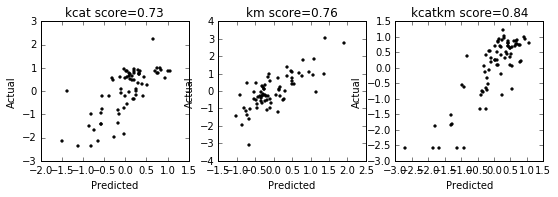

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import BaggingRegressor
from sklearn import preprocessing, cross_validation
from scipy.stats.stats import pearsonr

constants = [ 'kcat', 'km', 'kcatkm' ]

plt.figure( figsize=( 9, 2.5 ) ) 

for i, constant in enumerate( constants ):
    
    J = pandas.read_csv( 'training_sets/{}.csv'.format( constant ), index_col=0 ).as_matrix()  
    X = J[:, :-1]
    y = J[:, -1:].ravel()
    
    l1_ratio = [ .1, .5, .7, .9, .95, .99, 1 ]
    
    net = ElasticNetCV( l1_ratio=l1_ratio, cv=10, max_iter=-1 ) 
    bag = BaggingRegressor( net, n_estimators=30, n_jobs=-1, oob_score=True )
    bag.fit( X, y )
    preds = bag.predict( X )

    plt.subplot( 1, 3, i + 1 ) 
    plt.scatter( preds, y, marker='.', color='k' )
    plt.xlabel( 'Predicted' ); plt.ylabel( 'Actual' )
    r = pearsonr( preds, y )[0].round(2)
    plt.title( '{} pcc={}'.format( constant, r ) ) 

## Expression benchmark 

See if we can predict soluble expression given the set of 50 features output by Rosetta. 

In [1]:
features = [ u'total_score', u'fa_rep', u'hbond_sc', 
       u'tot_pstat_pm', u'tot_nlpstat_pm', u'tot_burunsat_pm', u'tot_hbond_pm',
       u'tot_NLconts_pm', u'tot_nlsurfaceE_pm', u'tot_total_charge',
       u'tot_total_pos_charges', u'tot_total_neg_charges', u'tot_seq_recovery',
       u'SR_1_total_score', u'SR_1_fa_rep', u'SR_1_hbond_sc',
       u'SR_1_hbond_pm', u'SR_1_burunsat_pm',
       u'SR_1_pstat_pm', u'SR_1_nlpstat_pm', u'SR_2_total_score',
       u'SR_2_fa_rep', u'SR_2_hbond_sc', u'SR_2_all_cst', u'SR_2_hbond_pm',
       u'SR_2_burunsat_pm', u'SR_2_pstat_pm', u'SR_2_nlpstat_pm', u'SR_3',
       u'SR_3_total_score', u'SR_3_fa_rep', u'SR_3_hbond_sc', u'SR_3_all_cst',
       u'SR_3_hbond_pm', u'SR_3_burunsat_pm', u'SR_3_pstat_pm',
       u'SR_3_nlpstat_pm', u'SR_4', u'SR_4_total_score', u'SR_4_fa_rep',
       u'SR_4_hbond_sc', u'SR_4_all_cst', u'SR_4_hbond_pm',
       u'SR_4_burunsat_pm', u'SR_4_pstat_pm', u'SR_4_nlpstat_pm', u'SR_5',
       u'SR_5_total_score', u'SR_5_fa_rep', u'SR_5_hbond_sc', u'SR_5_all_cst',
       u'SR_5_interf_E_1_2', u'SR_5_dsasa_1_2', u'SR_5_hbond_pm',
       u'SR_5_burunsat_pm', u'expression' ]

In [2]:
# test-versus-train style 

import pandas 
from sklearn import svm
from sklearn.ensemble import BaggingClassifier
%matplotlib inline 
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_curve

def low10( df ):
    return df.sort_values( by='total_score' ).head( 10 ).mean()

thermo = pandas.read_csv( 'data_sets/expression_data.csv', index_col='name' ) 
blind_data = pandas.read_csv( 'data_sets/expression_spring_2016.csv', index_col='name' )
sf = pandas.read_csv( 'data_sets/scorefile.csv' ) 
sf['name'] = sf.description.str.split( '_' ).str[ 1 ]

grouped = sf.groupby( 'name' )
low10 = grouped.apply( low10 )
#low10.index = low10.name 

joined_blind = low10.join( blind_data ).dropna() 

x = low10.join( thermo ).dropna()
x = x[ features ] 

y = x.expression.round()
X = x.drop( u'expression', axis=1 )

#y = x.expression * 2 # for multi-class

little_x = joined_blind[ features ]  
X_test = little_x.drop( 'expression', axis=1 ) 
y_test = joined_blind.expression.astype( bool ) 

clf = svm.SVC( kernel='linear', C=1 )
clf.fit( X, y )

#plot_decision_regions( X.as_matrix(), y.as_matrix(), classifier=clf )
#plt.legend(loc='upper left')
#plt.show()

print 'model score (training)', clf.score( X, y ).round( 2 )  
print 'model score (test)', clf.score( X_test, y_test ).round( 2 ) 

preds = clf.predict( X ) 
scores = clf.decision_function( X ) 

test_predictions = clf.predict( X_test ) 
test_scores = clf.decision_function( X_test ) 

fpr_train, tpr_train, __ = roc_curve( y, scores ) 
fpr_test, tpr_test, __ = roc_curve( y_test, test_scores ) 

plt.figure( figsize=(4,4) )
plt.plot( fpr_train, tpr_train ) 
plt.plot( fpr_test, tpr_test, color='r' ) 
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM results')
plt.legend( [ 'Training set (PLOS)', 'Test set (unpublished)' ], loc='lower right' )
plt.show()

IOError: File data_sets/expression_data.csv does not exist

model score (training) 0.74
model score (test) 0.58


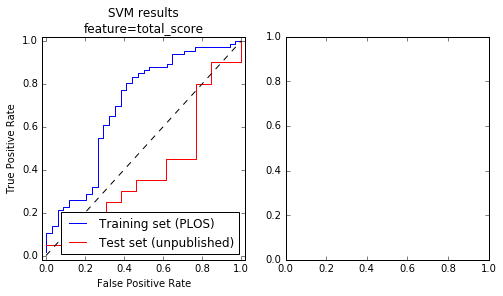

model score (training) 0.73
model score (test) 0.58


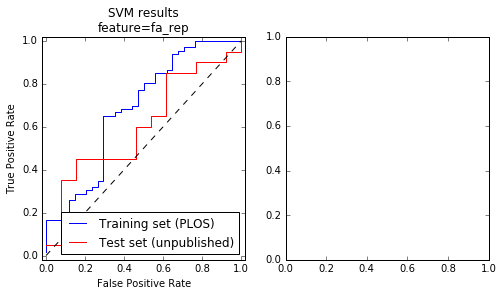

model score (training) 0.73
model score (test) 0.61


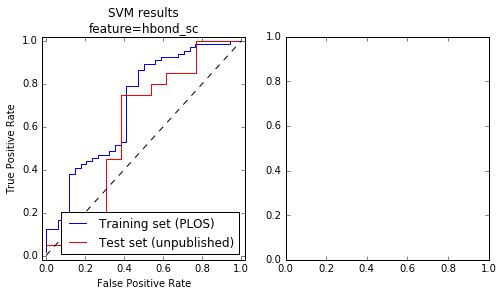

model score (training) 0.74
model score (test) 0.55


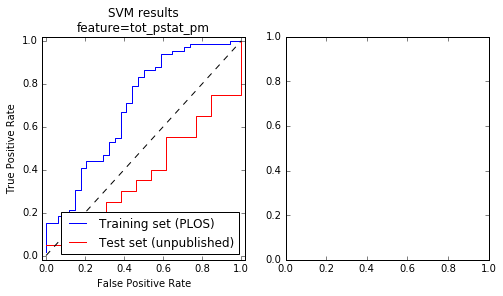

model score (training) 0.71
model score (test) 0.58


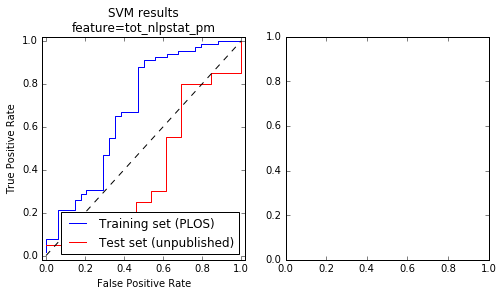

model score (training) 0.77
model score (test) 0.58


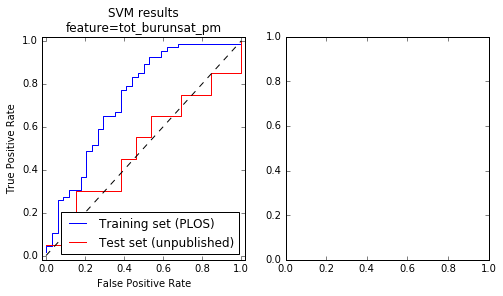

model score (training) 0.73
model score (test) 0.55


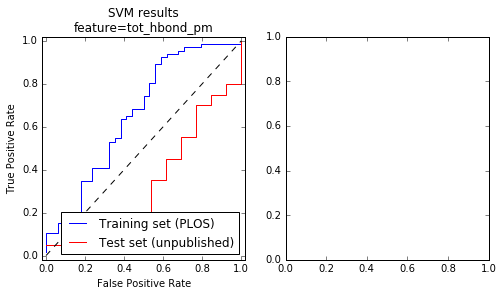

model score (training) 0.77
model score (test) 0.48


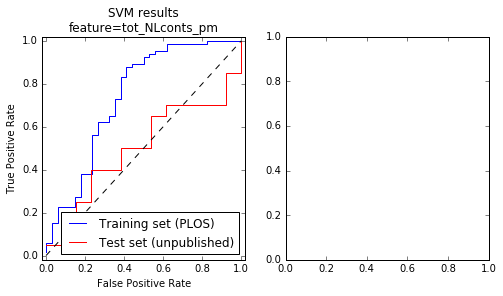

model score (training) 0.75
model score (test) 0.58


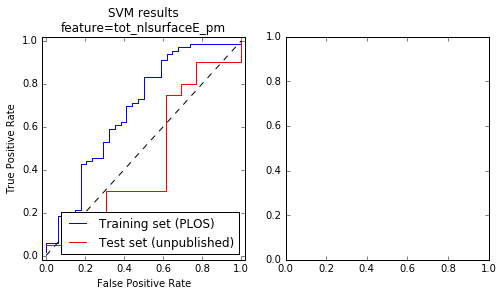

model score (training) 0.73
model score (test) 0.64


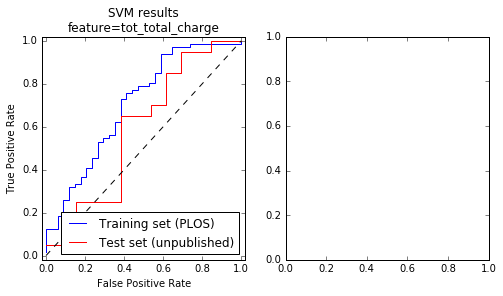

model score (training) 0.73
model score (test) 0.64


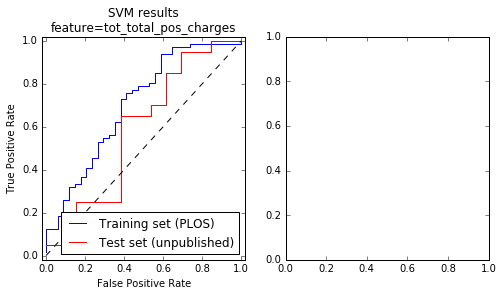

model score (training) 0.73
model score (test) 0.64


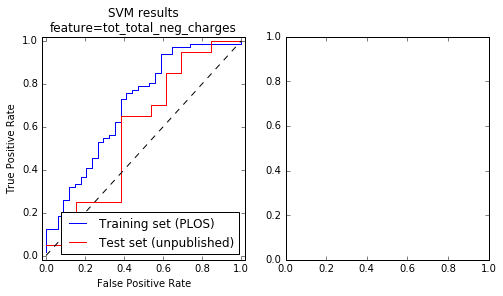

model score (training) 0.73
model score (test) 0.64


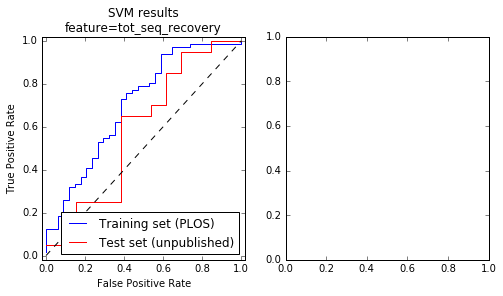

model score (training) 0.76
model score (test) 0.58


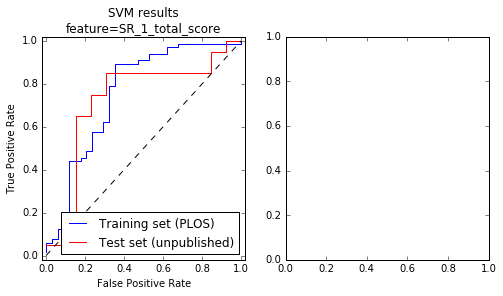

model score (training) 0.76
model score (test) 0.48


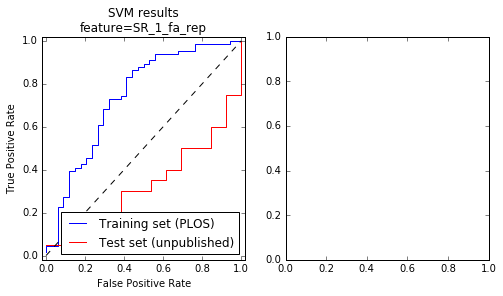

model score (training) 0.73
model score (test) 0.58


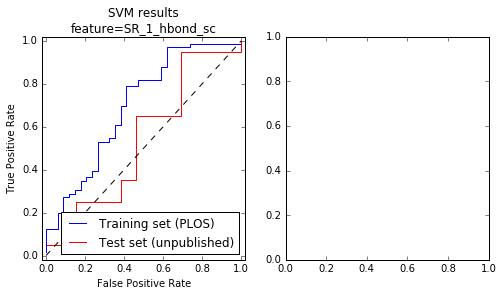

model score (training) 0.76
model score (test) 0.64


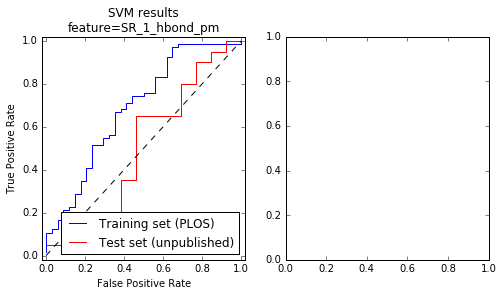

model score (training) 0.75
model score (test) 0.73


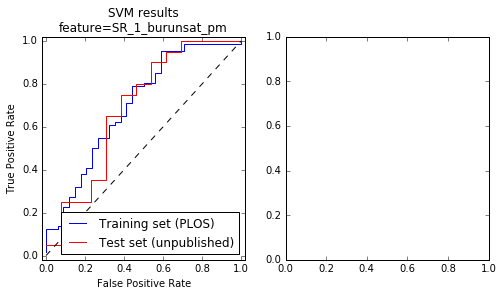

model score (training) 0.73
model score (test) 0.58


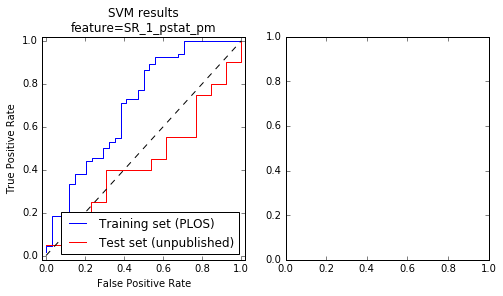

model score (training) 0.74
model score (test) 0.61


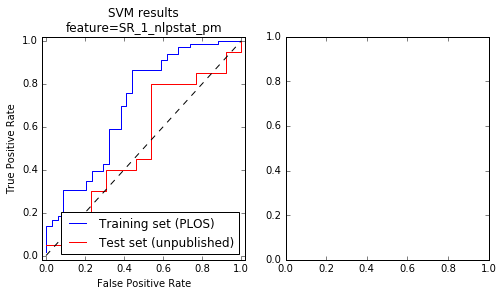

model score (training) 0.74
model score (test) 0.61


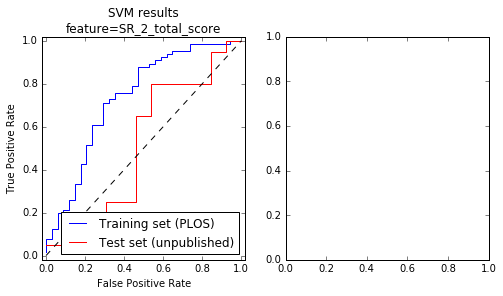

model score (training) 0.75
model score (test) 0.55


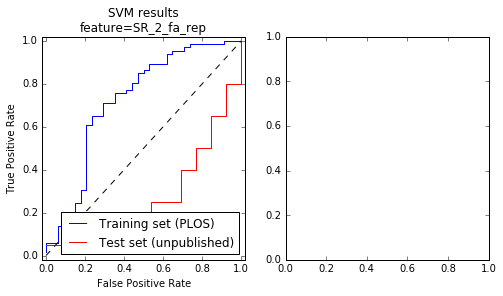

model score (training) 0.76
model score (test) 0.7


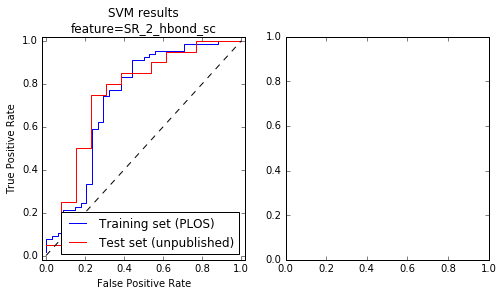

model score (training) 0.74
model score (test) 0.67


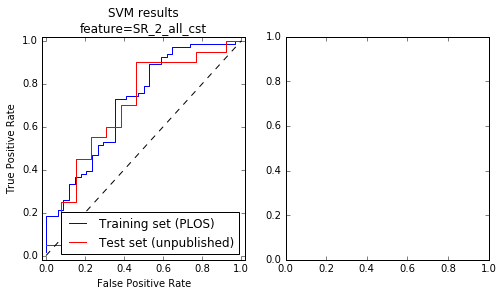

model score (training) 0.73
model score (test) 0.48


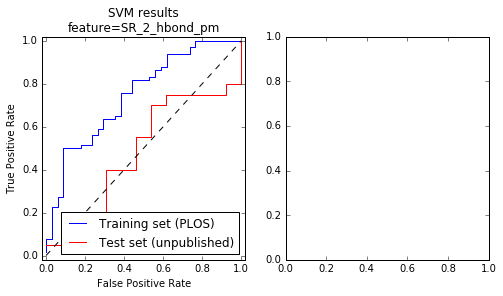

model score (training) 0.73
model score (test) 0.64


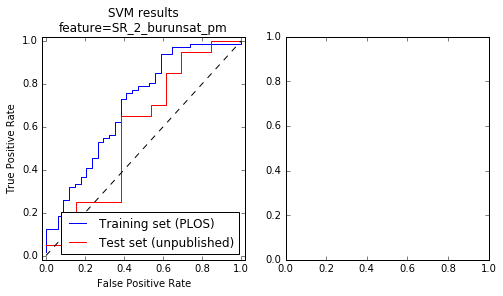

model score (training) 0.76
model score (test) 0.55


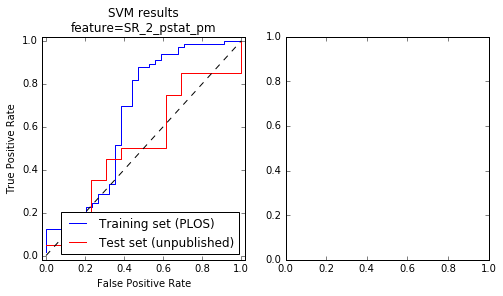

model score (training) 0.73
model score (test) 0.58


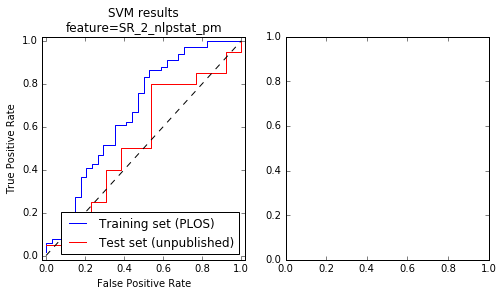

model score (training) 0.73
model score (test) 0.64


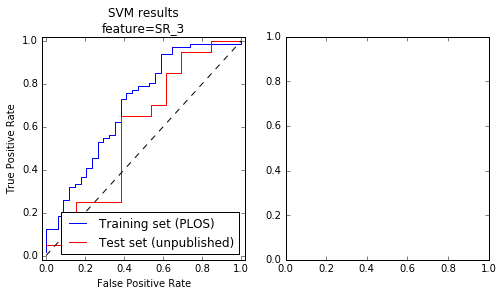

model score (training) 0.76
model score (test) 0.58


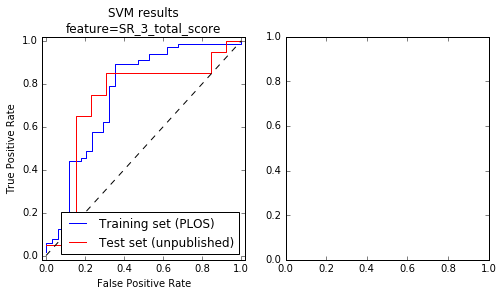

model score (training) 0.76
model score (test) 0.48


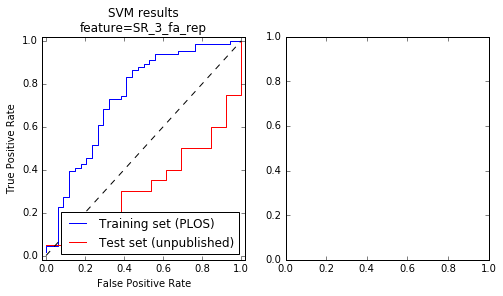

model score (training) 0.73
model score (test) 0.58


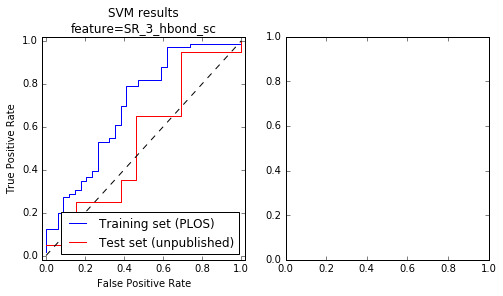

model score (training) 0.72
model score (test) 0.67


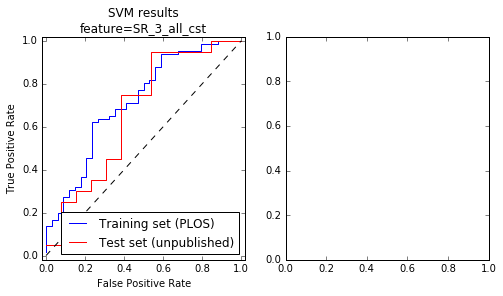

model score (training) 0.76
model score (test) 0.64


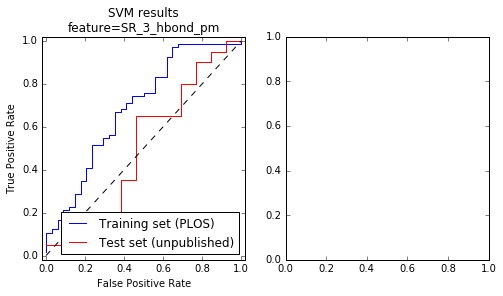

model score (training) 0.75
model score (test) 0.73


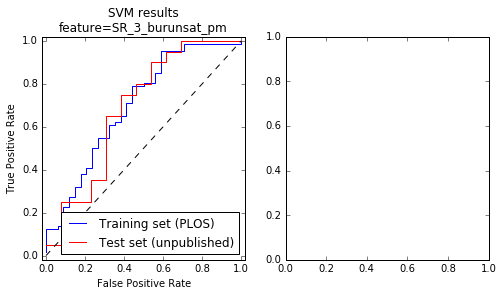

model score (training) 0.73
model score (test) 0.58


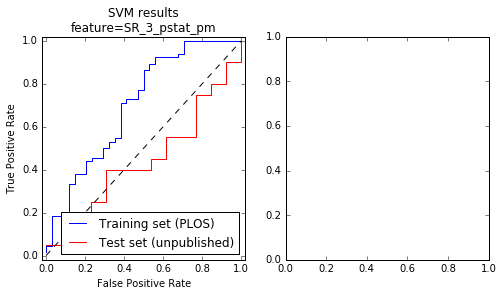

In [3]:
# test-versus-train style 

import pandas 
from sklearn import svm
from sklearn.ensemble import BaggingClassifier
%matplotlib inline 
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_curve

features = [ u'total_score', u'fa_rep', u'hbond_sc', 
       u'tot_pstat_pm', u'tot_nlpstat_pm', u'tot_burunsat_pm', u'tot_hbond_pm',
       u'tot_NLconts_pm', u'tot_nlsurfaceE_pm', u'tot_total_charge',
       u'tot_total_pos_charges', u'tot_total_neg_charges', u'tot_seq_recovery',
       u'SR_1_total_score', u'SR_1_fa_rep', u'SR_1_hbond_sc',
       u'SR_1_hbond_pm', u'SR_1_burunsat_pm',
       u'SR_1_pstat_pm', u'SR_1_nlpstat_pm', u'SR_2_total_score',
       u'SR_2_fa_rep', u'SR_2_hbond_sc', u'SR_2_all_cst', u'SR_2_hbond_pm',
       u'SR_2_burunsat_pm', u'SR_2_pstat_pm', u'SR_2_nlpstat_pm', u'SR_3',
       u'SR_3_total_score', u'SR_3_fa_rep', u'SR_3_hbond_sc', u'SR_3_all_cst',
       u'SR_3_hbond_pm', u'SR_3_burunsat_pm', u'SR_3_pstat_pm',
       u'SR_3_nlpstat_pm', u'SR_4', u'SR_4_total_score', u'SR_4_fa_rep',
       u'SR_4_hbond_sc', u'SR_4_all_cst', u'SR_4_hbond_pm',
       u'SR_4_burunsat_pm', u'SR_4_pstat_pm', u'SR_4_nlpstat_pm', u'SR_5',
       u'SR_5_total_score', u'SR_5_fa_rep', u'SR_5_hbond_sc', u'SR_5_all_cst',
       u'SR_5_interf_E_1_2', u'SR_5_dsasa_1_2', u'SR_5_hbond_pm',
       u'SR_5_burunsat_pm', u'expression' ]

def my_big_dumb_function( feature='total_score' ):
    
    def low10( df ):
        return df.sort_values( by=feature ).head( 10 ).mean()

    thermo = pandas.read_csv( 'data_sets/expression_data.csv', index_col='name' ) 
    blind_data = pandas.read_csv( 'data_sets/expression_spring_2016.csv', index_col='name' )
    sf = pandas.read_csv( 'data_sets/scorefile.csv' ) 
    sf['name'] = sf.description.str.split( '_' ).str[ 1 ]

    grouped = sf.groupby( 'name' )
    low10 = grouped.apply( low10 )

    joined_blind = low10.join( blind_data ).dropna() 

    x = low10.join( thermo ).dropna()
    x = x[ features ] 

    y = x.expression.round()
    X = x.drop( u'expression', axis=1 )

    #y = x.expression * 2 # for multi-class

    little_x = joined_blind[ features ]  
    X_test = little_x.drop( 'expression', axis=1 ) 
    y_test = joined_blind.expression.astype( bool ) 

    clf = svm.SVC( kernel='linear', C=1 )
    clf.fit( X, y )

    print 'model score (training)', clf.score( X, y ).round( 2 )  
    print 'model score (test)', clf.score( X_test, y_test ).round( 2 ) 

    preds = clf.predict( X ) 
    scores = clf.decision_function( X ) 

    test_predictions = clf.predict( X_test ) 
    test_scores = clf.decision_function( X_test ) 

    fpr_train, tpr_train, __ = roc_curve( y, scores ) 
    fpr_test, tpr_test, __ = roc_curve( y_test, test_scores ) 

    plt.figure( figsize=(8,4) )
    plt.subplot( 1, 2, 1 ) 
    plt.plot( fpr_train, tpr_train ) 
    plt.plot( fpr_test, tpr_test, color='r' ) 
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('SVM results\nfeature={}'.format( feature ) )
    plt.legend( [ 'Training set (PLOS)', 'Test set (unpublished)' ], loc='lower right' )
    
    plt.subplot( 1, 2, 2 )
    
    plt.show()
    
ff = features[:-20]
for f in ff:
    my_big_dumb_function( feature=f )

In [ ]:
# stratified cross-validation style 

%matplotlib inline 
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_curve
from sklearn import cross_validation, svm
from sklearn.ensemble import BaggingClassifier
import pandas 

def low10( df ):
    return df.sort_values( by='total_score' ).head( 2 ) #.mean()

thermo = pandas.read_csv( 'data_sets/expression_cat.csv', index_col='name' ) 
sf = pandas.read_csv( 'data_sets/scorefile.csv' ) 
sf['name'] = sf.description.str.split( '_' ).str[ 1 ]

grouped = sf.groupby( 'name' )
low10 = grouped.apply( low10 )
low10.index = low10.name 

x = low10.join( thermo ).dropna()
x = x[ features ] 

y = x.expression.round().as_matrix()
X = x.drop( u'expression', axis=1 ).as_matrix()

clf = svm.SVC( kernel='linear', C=1 )
skf = cross_validation.StratifiedKFold( y, n_folds=10 )
bag = BaggingClassifier( clf, n_estimators=1, n_jobs=-1 ) 

#print [ clf.fit( X[train], y[train] ).score( X[test], y[test] ) for train, test in skf ]
#print cross_validation.cross_val_score( bag, X, y, cv=skf, n_jobs=-1)

for train, test in skf: 
    bag.fit( X[train], y[train] ) 

# print 'model score (training)', clf.score( X, y ).round( 2 )  
# print 'model score (test)', clf.score( X_test, y_test ).round( 2 ) 

# preds = clf.predict( X ) 
# scores = clf.decision_function( X ) 

# test_predictions = clf.predict( X_test ) 
# test_scores = clf.decision_function( X_test ) 

# fpr_train, tpr_train, __ = roc_curve( y, scores ) 
# fpr_test, tpr_test, __ = roc_curve( y_test, test_scores ) 

# plt.figure( figsize=(4,4) )
# plt.plot( fpr_train, tpr_train ) 
# plt.plot( fpr_test, tpr_test, color='r' ) 
# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlim([-0.02, 1.02])
# plt.ylim([-0.02, 1.02])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('SVM results')
# plt.legend( [ 'Training set (PLOS)', 'Test set (unpublished)' ], loc='lower right' )
# plt.show()

model score 0.83


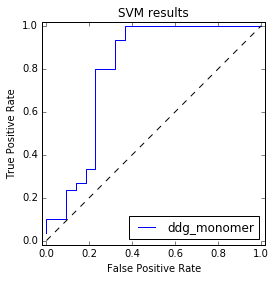

In [35]:
# using ddg predictions as features instead of enzdes features 

import pandas 
from sklearn import svm
from sklearn.ensemble import BaggingClassifier
%matplotlib inline 
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_curve

def low10( df ):
    return df.sort_values( by='total_score' ).head( 10 ) #.mean()

expr = pandas.read_csv( 'data_sets/expression_cat.csv', index_col='name' ) 
sf = pandas.read_csv( '~/Documents/bagel-thermostability/protocols/ddg/ddg_preds.csv', index_col='description' ) 

ddg_features = [ u'total', u'fa_atr', u'fa_rep', u'fa_sol',
       u'fa_intra_rep', u'fa_elec', u'pro_close', u'hbond_sr_bb',
       u'hbond_lr_bb', u'hbond_bb_sc', u'hbond_sc', u'dslf_fa13',
       u'coordinate_constraint', u'angle_constraint', u'dihedral_constraint',
       u'rama', u'omega', u'fa_dun', u'p_aa_pp', u'ref', u'chainbreak',
       u'res_type_constraint' ]

x = expr.join( sf ).dropna() 
X = x[ ddg_features ] 
y = x.expression.round()

clf = svm.SVC( kernel='linear', C=1 )
clf.fit( X, y ) 

print 'model score', clf.score( X, y ).round( 2 )  

preds = clf.predict( X ) 
scores = clf.decision_function( X ) 

fpr_train, tpr_train, __ = roc_curve( y, scores ) 

plt.figure( figsize=(4,4) )
plt.plot( fpr_train, tpr_train ) 
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM results')
plt.legend( [ 'ddg_monomer' ], loc='lower right' )
plt.show()

In [ ]:
# bootstrapping SVM on all expression data we have 

import pandas 
from sklearn import svm
from sklearn.ensemble import BaggingClassifier
%matplotlib inline 
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_curve

def low10( df ):
    return df.sort_values( by='total_score' ).head( 10 ) #.mean()

thermo = pandas.read_csv( 'data_sets/expression_cat.csv', index_col='name' ) 
sf = pandas.read_csv( 'data_sets/scorefile.csv' ) 
sf['name'] = sf.description.str.split( '_' ).str[ 1 ]

grouped = sf.groupby( 'name' )
low10 = grouped.apply( low10 )
low10.index = low10.name 

joined_blind = low10.join( blind_data ).dropna() 

x = low10.join( thermo ).dropna()
x = x[ features ] 

y = x.expression.round()
X = x.drop( u'expression', axis=1 )

clf = svm.SVC( kernel='rbf', C=1 )
clf.fit( X, y ) 

print 'model score', clf.score( X, y ).round( 2 )  

preds = clf.predict( X ) 
scores = clf.decision_function( X ) 

fpr_train, tpr_train, __ = roc_curve( y, scores ) 

plt.figure( figsize=(4,4) )
plt.plot( fpr_train, tpr_train ) 
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM results')
plt.legend( [ 'All expression data' ], loc='lower right' )
plt.show()

### Sampling all of the features 10 highest and 10 lowest rows to see if any of them improve EN performance 

In [1]:
# try sampling all the features to pick the lowest 10 models 

import pandas 
from numpy import inf, nan, log 
from sklearn import preprocessing 

def pick_n_models( df, feature, n, ascending=True ):
    return df.sort_values( by=feature, ascending=ascending ).head( n ).mean()

# Rosetta features for 17400 Bagel protein models 
sf = pandas.read_csv( 'data_sets/scorefile.csv' )
grouped = sf.groupby( 'name' )

# constants to be included 
constants = [ 'kcat', 'km', 'kcatkm' ]

# features to be included 
features = [ u'total_score', u'fa_rep', u'hbond_sc', u'tot_pstat_pm',
       u'tot_nlpstat_pm', u'tot_burunsat_pm', u'tot_hbond_pm',
       u'tot_NLconts_pm', u'tot_nlsurfaceE_pm', u'tot_total_charge',
       u'tot_total_pos_charges', u'tot_total_neg_charges', 
       u'SR_1_total_score', u'SR_1_fa_rep', u'SR_1_hbond_sc',
       u'SR_1_hbond_pm', u'SR_1_burunsat_pm',
       u'SR_1_pstat_pm', u'SR_1_nlpstat_pm', u'SR_2_total_score',
       u'SR_2_fa_rep', u'SR_2_hbond_sc', u'SR_2_hbond_pm',
       u'SR_2_burunsat_pm', u'SR_2_pstat_pm', u'SR_2_nlpstat_pm',
       u'SR_3_total_score', u'SR_3_fa_rep', u'SR_3_hbond_sc', 
       u'SR_3_hbond_pm', u'SR_3_burunsat_pm', u'SR_3_pstat_pm',
       u'SR_3_nlpstat_pm', u'SR_4_total_score', u'SR_4_fa_rep',
       u'SR_4_hbond_sc', u'SR_4_hbond_pm',
       u'SR_4_burunsat_pm', u'SR_4_pstat_pm', u'SR_4_nlpstat_pm',
       u'SR_5_total_score', u'SR_5_fa_rep', u'SR_5_hbond_sc', 
       u'SR_5_interf_E_1_2', u'SR_5_dsasa_1_2', u'SR_5_hbond_pm',
       u'SR_5_burunsat_pm', ] 

# experimental data, and also log compared to wild type 
dat = pandas.read_csv( '../bagel-data/clean_data/plos2015.csv', index_col='name' )
wt = dat.loc[ 'BglB' ]
dat.drop( [ 'BglB' ], inplace=True )
dat = log( dat / wt )

feature_sets = []

for constant in constants:
    
    y = dat[ [ constant ] ] 
    print constant, 
    
    for a in [ True, False ]:
        
        for feature in features:
            
            print '.', 
            X = grouped.apply( pick_n_models, feature, 10, a )[ features ]
            J = X.join( y ).replace( [ inf, -inf ], nan ).dropna()
            
            scaler = preprocessing.StandardScaler()
            J = scaler.fit_transform( J )

            feature_sets.append( ( constant, a, feature, J ) )
            
    print ''

kcat . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
km . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
kcatkm . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 


In [28]:
import pickle

with open( 'feature_sets.pkl', 'w' ) as fn:
    pickle.dump( feature_sets, fn ) 

In [29]:
# try EN on all feature sets

%matplotlib inline
import matplotlib.pyplot as plt 
from sklearn import cross_validation, preprocessing
from sklearn.linear_model import ElasticNetCV, SGDRegressor
from sklearn.ensemble import BaggingRegressor
from scipy.stats.stats import pearsonr
from numpy import log, mean
from glob import glob 
import pandas

scores = []

classifiers = [ 
    ( 'EN_auto_L1', ElasticNetCV( selection='random', cv=10 ) ),  
    ( 'SGD', SGDRegressor( penalty='elasticnet' ) ),  # stochastic gradient descent
    ( 'EN_with_manual_L1_ratio', ElasticNetCV( l1_ratio=[.1, .5, .7, .9, .95, .99, 1], cv=10 ) ), 
    ( 'EN_with_bagging', BaggingRegressor( ElasticNetCV( l1_ratio=[.1, .5, .7, .9, .95, .99, 1], cv=10 ), n_estimators=10 ) ), 
]

with open( 'feature_sets.pkl' ) as fn:
    loaded_feature_sets = pickle.load( fn ) 
    
for ( constant, a, feature, J ) in loaded_feature_sets:
    
    X = J[:, :-1]
    y = J[:, -1:].ravel()
    
    for clf_short_name, clf in classifiers:

        result = {
            'classifier_short_name': clf_short_name,
            'classifier': clf.fit( X, y ),
            'y': y, 
            'predictions': clf.predict( X ), 
            'score': clf.score( X, y ),
            'constant': constant, 
            'ascending': a, 
            'feature': feature, 
        }
        
        scores.append( result ) 

scores = pandas.DataFrame( scores )
scores.to_pickle( 'scores.pkl' ) 

In [3]:
import pickle

with open( 'scores.pkl' ) as fn:
    loaded_scores = pickle.load( fn ) 

In [4]:
loaded_scores.columns

Index([u'ascending', u'classifier', u'classifier_short_name', u'constant',
       u'feature', u'predictions', u'score', u'y'],
      dtype='object')

In [6]:
loaded_scores[ ( loaded_scores.feature == 'total_score' ) ] 

,ascending,classifier,classifier_short_name,constant,feature,predictions,score,y
0,True,"ElasticNetCV(alphas=None, copy_X=True, cv=10, ...",EN_auto_L1,kcat,total_score,"[1.01285223076e-16, 1.01285223076e-16, 1.01285...",0.000000,"[0.930228452973, 0.567303558594, 0.59443494529..."
1,True,"SGDRegressor(alpha=0.0001, average=False, epsi...",SGD,kcat,total_score,"[-0.197054256547, -0.0302018381336, 0.63401983...",0.470858,"[0.930228452973, 0.567303558594, 0.59443494529..."
2,True,"ElasticNetCV(alphas=None, copy_X=True, cv=10, ...",EN_with_manual_L1_ratio,kcat,total_score,"[1.01664015405e-16, 1.01664015405e-16, 1.01664...",0.000000,"[0.930228452973, 0.567303558594, 0.59443494529..."
3,True,"(ElasticNetCV(alphas=None, copy_X=True, cv=10,...",EN_with_bagging,kcat,total_score,"[0.00520045820949, 0.107679297123, 0.277481232...",0.434672,"[0.930228452973, 0.567303558594, 0.59443494529..."
188,False,"ElasticNetCV(alphas=None, copy_X=True, cv=10, ...",EN_auto_L1,kcat,total_score,"[-0.0450870817588, 0.126963009428, -0.07583143...",0.094020,"[0.930228452973, 0.567303558594, 0.59443494529..."
189,False,"SGDRegressor(alpha=0.0001, average=False, epsi...",SGD,kcat,total_score,"[-0.112435529893, 0.469026735066, 0.3236091911...",0.440326,"[0.930228452973, 0.567303558594, 0.59443494529..."
190,False,"ElasticNetCV(alphas=None, copy_X=True, cv=10, ...",EN_with_manual_L1_ratio,kcat,total_score,"[-0.0541025591361, 0.15290174869, -0.090035070...",0.111059,"[0.930228452973, 0.567303558594, 0.59443494529..."
191,False,"(ElasticNetCV(alphas=None, copy_X=True, cv=10,...",EN_with_bagging,kcat,total_score,"[-0.111862645461, 0.393703681718, 0.3780153129...",0.448263,"[0.930228452973, 0.567303558594, 0.59443494529..."
376,True,"ElasticNetCV(alphas=None, copy_X=True, cv=10, ...",EN_auto_L1,km,total_score,"[-0.17051872418, -0.160064599545, 0.1438014288...",0.331527,"[-0.510559319287, 0.797135542277, -0.552825228..."
377,True,"SGDRegressor(alpha=0.0001, average=False, epsi...",SGD,km,total_score,"[-0.107044293417, -0.296201454035, -0.46451953...",0.514438,"[-0.510559319287, 0.797135542277, -0.552825228..."


In [30]:
def my_function( df ):
    return df.sort_values( 'score', ascending=False ).head( 5 ) 

low5 = scores.groupby( 'constant' ).apply( my_function ) 

print low5.columns

Index([u'ascending', u'classifier', u'classifier_short_name', u'constant',
       u'feature', u'predictions', u'score', u'y'],
      dtype='object')


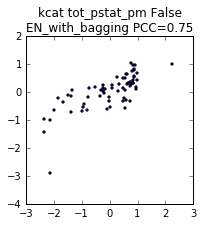

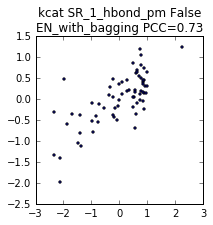

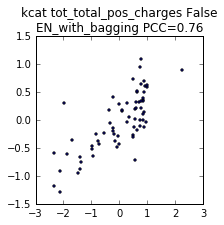

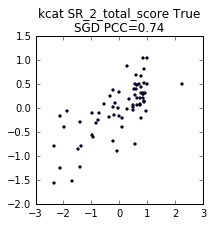

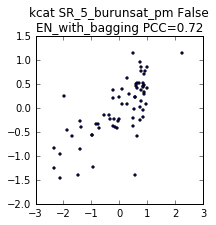

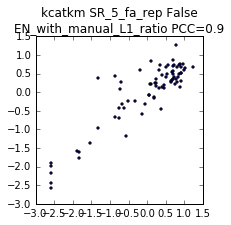

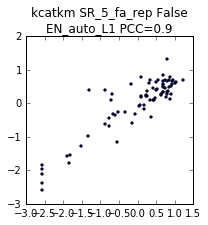

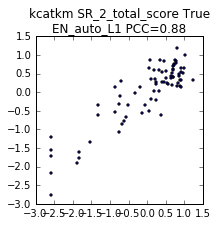

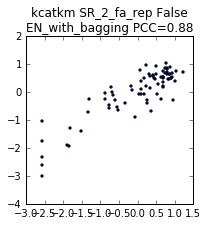

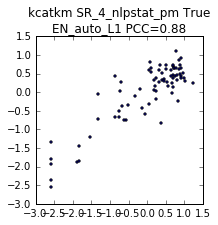

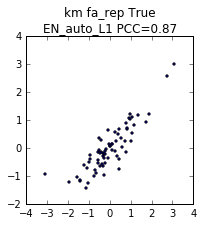

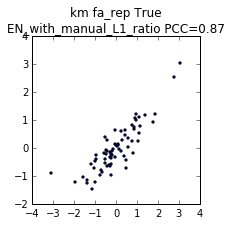

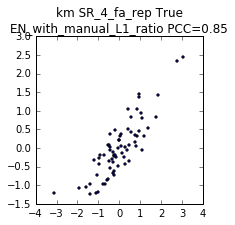

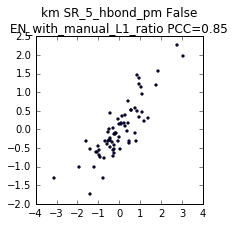

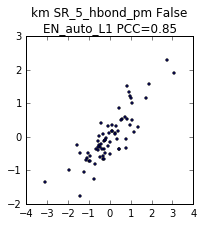

In [32]:
# with the bagging classifier 

for name, s in low5.iterrows():

    pcc = pearsonr( s.y, s.predictions )[0].round( 2 )  
    plt.figure( figsize=(3,3) ) 
    plt.title( '{} {} {}\n{} PCC={}'.format( s.constant, s.feature, s.ascending, s.classifier_short_name, pcc ) )
    plt.scatter( s.y, s.predictions, marker='.' ) 
    plt.show()



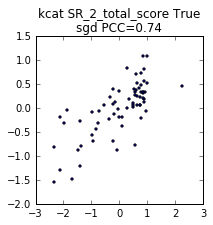

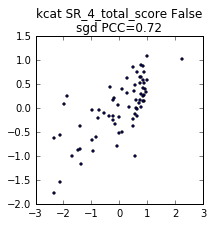

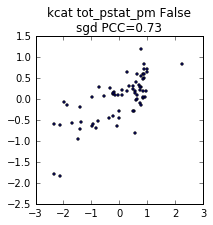

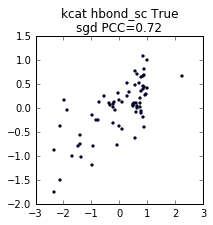

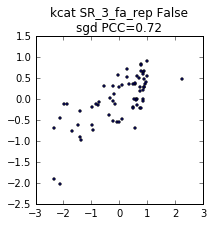

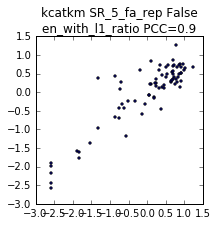

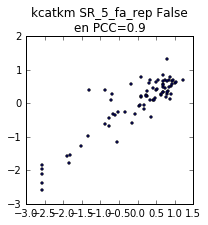

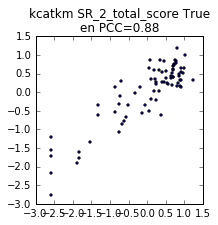

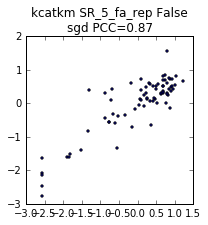

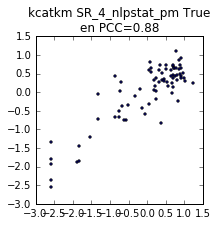

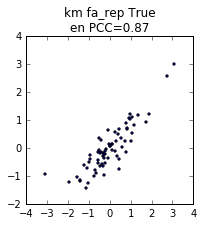

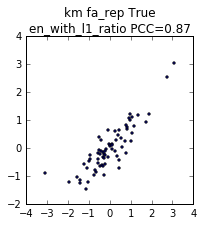

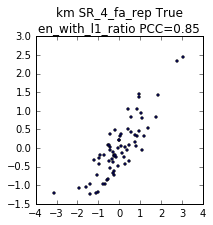

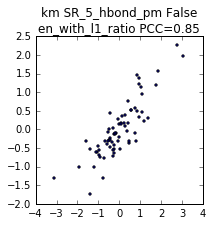

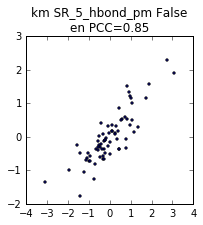

In [27]:
# without the bagging classifier 

for name, s in low5.iterrows():

    pcc = pearsonr( s.y, s.predictions )[0].round( 2 )  
    plt.figure( figsize=(3,3) ) 
    plt.title( '{} {} {}\n{} PCC={}'.format( s.constant, s.feature, s.ascending, s.classifier_short_name, pcc ) )
    plt.scatter( s.y, s.predictions, marker='.' ) 
    plt.show()


## Additional features

### Distance from active site 

In [41]:
# add distance from active site as a feature for every possible mutation  

from Bio.PDB.PDBParser import PDBParser 
from Bio.SeqUtils import IUPACData

parser = PDBParser()
structure = parser.get_structure( 'bglb', 'bglb.pdb' )

ligand = structure[0]['X']
for i in ligand:
    ligand_centroid = i['C5'] 

chain_a = structure[0]['A']
    
l = []
for i in range( 1, 445 ):
    res = chain_a[ i ]
    n = IUPACData.protein_letters_3to1[ res.get_resname().capitalize() ] 
    atom_1 = res['CA']
    distance = atom_1 - ligand_centroid
    for aa in IUPACData.protein_letters:
        l.append( ( '{}{}{}'.format( n, i, aa.upper() ), distance ) ) 
    
df = pandas.DataFrame( l, columns=[ 'name', 'distance' ] )  


df.to_csv( 'data_sets/distance_from_active_site.csv' ) 

## Stratch 

In [31]:
# Author: Andreas Mueller <amueller@ais.uni-bonn.de>
#
# License: BSD 3 clause

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest

iris = load_iris()

X, y = iris.data, iris.target

# This dataset is way to high-dimensional. Better do PCA:
pca = PCA(n_components=2)

# Maybe some original features where good, too?
selection = SelectKBest(k=1)

# Build estimator from PCA and Univariate selection:

combined_features = FeatureUnion([("pca", pca), ("univ_select", selection)])

# Use combined features to transform dataset:
X_features = combined_features.fit(X, y).transform(X)

svm = SVC(kernel="linear")

# Do grid search over k, n_components and C:

pipeline = Pipeline([("features", combined_features), ("svm", svm)])

param_grid = dict(features__pca__n_components=[1, 2, 3],
                  features__univ_select__k=[1, 2],
                  svm__C=[0.1, 1, 10])

grid_search = GridSearchCV(pipeline, param_grid=param_grid, verbose=10)
grid_search.fit(X, y)
print(grid_search.best_estimator_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] features__pca__n_components=1, svm__C=0.1, features__univ_select__k=1 
[CV]  features__pca__n_components=1, svm__C=0.1, features__univ_select__k=1, score=0.960784 -   0.0s
[CV] features__pca__n_components=1, svm__C=0.1, features__univ_select__k=1 
[CV]  features__pca__n_components=1, svm__C=0.1, features__univ_select__k=1, score=0.901961 -   0.0s
[CV] features__pca__n_components=1, svm__C=0.1, features__univ_select__k=1 
[CV]  features__pca__n_components=1, svm__C=0.1, features__univ_select__k=1, score=0.979167 -   0.0s
[CV] features__pca__n_components=1, svm__C=1, features__univ_select__k=1 
[CV]  features__pca__n_components=1, svm__C=1, features__univ_select__k=1, score=0.941176 -   0.0s

[Parallel(n_jobs=1)]: Done   1 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   7 tasks       | elapsed:    0.1s



[CV] features__pca__n_components=1, svm__C=1, features__univ_select__k=1 
[CV]  features__pca__n_components=1, svm__C=1, features__univ_select__k=1, score=0.921569 -   0.0s
[CV] features__pca__n_components=1, svm__C=1, features__univ_select__k=1 
[CV]  features__pca__n_components=1, svm__C=1, features__univ_select__k=1, score=0.979167 -   0.0s
[CV] features__pca__n_components=1, svm__C=10, features__univ_select__k=1 
[CV]  features__pca__n_components=1, svm__C=10, features__univ_select__k=1, score=0.960784 -   0.0s
[CV] features__pca__n_components=1, svm__C=10, features__univ_select__k=1 
[CV]  features__pca__n_components=1, svm__C=10, features__univ_select__k=1, score=0.921569 -   0.0s
[CV] features__pca__n_components=1, svm__C=10, features__univ_select__k=1 
[CV]  features__pca__n_components=1, svm__C=10, features__univ_select__k=1, score=0.979167 -   0.0s
[CV] features__pca__n_components=1, svm__C=0.1, features__univ_select__k=2 
[CV]  features__pca__n_components=1, svm__C=0.1, fea

[Parallel(n_jobs=1)]: Done  12 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks       | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  24 tasks       | elapsed:    0.2s



[CV] features__pca__n_components=2, svm__C=1, features__univ_select__k=1 
[CV]  features__pca__n_components=2, svm__C=1, features__univ_select__k=1, score=0.941176 -   0.0s
[CV] features__pca__n_components=2, svm__C=1, features__univ_select__k=1 
[CV]  features__pca__n_components=2, svm__C=1, features__univ_select__k=1, score=0.979167 -   0.0s
[CV] features__pca__n_components=2, svm__C=10, features__univ_select__k=1 
[CV]  features__pca__n_components=2, svm__C=10, features__univ_select__k=1, score=0.980392 -   0.0s
[CV] features__pca__n_components=2, svm__C=10, features__univ_select__k=1 
[CV]  features__pca__n_components=2, svm__C=10, features__univ_select__k=1, score=0.941176 -   0.0s
[CV] features__pca__n_components=2, svm__C=10, features__univ_select__k=1 
[CV]  features__pca__n_components=2, svm__C=10, features__univ_select__k=1, score=0.979167 -   0.0s
[CV] features__pca__n_components=2, svm__C=0.1, features__univ_select__k=2 
[CV]  features__pca__n_components=2, svm__C=0.1, fea

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:    0.4s



[CV]  features__pca__n_components=3, svm__C=0.1, features__univ_select__k=1, score=0.979167 -   0.0s
[CV] features__pca__n_components=3, svm__C=1, features__univ_select__k=1 
[CV]  features__pca__n_components=3, svm__C=1, features__univ_select__k=1, score=1.000000 -   0.0s
[CV] features__pca__n_components=3, svm__C=1, features__univ_select__k=1 
[CV]  features__pca__n_components=3, svm__C=1, features__univ_select__k=1, score=0.941176 -   0.0s
[CV] features__pca__n_components=3, svm__C=1, features__univ_select__k=1 
[CV]  features__pca__n_components=3, svm__C=1, features__univ_select__k=1, score=0.979167 -   0.0s
[CV] features__pca__n_components=3, svm__C=10, features__univ_select__k=1 
[CV]  features__pca__n_components=3, svm__C=10, features__univ_select__k=1, score=1.000000 -   0.0s
[CV] features__pca__n_components=3, svm__C=10, features__univ_select__k=1 
[CV]  features__pca__n_components=3, svm__C=10, features__univ_select__k=1, score=0.921569 -   0.0s
[CV] features__pca__n_compone

[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:    0.5s finished


In [176]:
# clean try at it (what?)

In [199]:
# features 

f = pandas.DataFrame()

# distance from active site 

distance_features = pandas.read_csv( 'data_sets/distance_from_active_site.csv', index_col=0 ) 
distance_features.set_index( 'name', inplace=True ) 

print distance_features.sample( 5 ) 

f['distance'] = distance_features.distance

print f.sample( 5 ) 
print len( f ), 'rows'

        distance
name            
D288G  21.533550
C54L   17.077085
R385R  23.580620
L171F  12.435019
L434M  22.921677
        distance
name            
H328T  17.296524
P319F  20.129499
K442Y  28.076277
Q69Q   25.309523
T2E    29.248558
8880 rows


In [200]:
# blosum scores from flat file 
# ftp://ftp.ncbi.nih.gov/blast/matrices/BLOSUM62

bsm = pandas.read_csv( 'blosum62.txt', sep='\s+', index_col=0 ) 
f['blosum62'] = [ bsm[ i[0] ][ i[-1] ] for i in f.index ]
print f.sample( 5 ) 
print len( f ), 'rows' 

        distance  blosum62
name                      
Y295I   8.555000        -1
D55K   19.611868        -1
A192W  16.758543        -3
F332D  15.382276        -3
S169N  13.790542         1
8880 rows


In [201]:
# ddg_monomer features 

ddg = pandas.read_csv( '/Users/alex/Documents/bagel-thermostability/protocols/results/apo_kellogg.out', sep='\s+', index_col='description' ).drop( 'ddG:', axis=1 )
f = f.join( ddg ).dropna()
print len( f ) 

68


In [202]:
# enzyme design features 

enzdes = pandas.read_csv( 'data_sets/scorefile.csv', index_col=0 )
enzdes = enzdes.groupby( 'name' ).apply( lambda x : x.head(10).mean() ) 

#enzdes.groupby( 'name' ).mean() 
#enzdes.set_index( 'name', inplace=True ) 
# = f.join( enzdes, rsuffix='_enzdes' ).dropna() #
#print len( f )

In [204]:
f.index - enzdes.index

/usr/local/bin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
  if __name__ == '__main__':


Index([u'E164A', u'E164G', u'E164R', u'E353A', u'G174R', u'L122E', u'L122N',
       u'L402C', u'R297F', u'S169P', u'Y295A', u'Y295G', u'Y75H'],
      dtype='object')

In [223]:
import screed 

complete_list = []

for record in screed.open( 'bglb.fasta' ):
    for index, letter in enumerate( record.sequence ):
        for new_letter in 'ACDEFGHIKLMNPQRSTVWY':
            complete_list.append( letter + str( index + 1 ) + new_letter )
            
len( complete_list ) 

8900

In [224]:
lis = pandas.read_csv( 'mutant_list', header=None, names=['name'], index_col=0 ) 

d = f.index.difference( enzdes.index ).difference( lis.index ) 

In [226]:
for m in d:
    print m in complete_list 


True
True
True
True
True
True
True


In [181]:
# join with experimental 

# read in data 
# clean up data 

import pandas 

df = pandas.read_csv( 'data_sets/expression_cat.csv' ) 
df['expression'] = ( df.expression + 0.5 ) // 1 
df.dropna( inplace=True ) 
df.set_index( 'name', inplace=True ) 

J = f.join( df ).dropna() 
J.to_csv( 'J.csv' ) 
print len( J ) 

# select features 

select = ['distance', 'blosum62', 'total', 'fa_atr', 'fa_rep', 'fa_sol', 'fa_intra_rep', 'fa_elec', 'pro_close', 'hbond_sr_bb', 'hbond_lr_bb', 'hbond_bb_sc', 'hbond_sc', 'dslf_fa13', 'coordinate_constraint', 'angle_constraint', 'dihedral_constraint', 'rama', 'omega', 'fa_dun', 'p_aa_pp', 'ref', 'chainbreak', 'res_type_constraint', 'total_score', 'fa_rep_enzdes', 'hbond_sc_enzdes', 'all_cst', 'tot_pstat_pm', 'tot_nlpstat_pm', 'tot_burunsat_pm', 'tot_hbond_pm', 'tot_NLconts_pm', 'tot_nlsurfaceE_pm', 'tot_total_charge', 'tot_total_pos_charges', 'tot_total_neg_charges', 'tot_seq_recovery', 'SR_1', 'SR_1_total_score', 'SR_1_fa_rep', 'SR_1_hbond_sc', 'SR_1_all_cst', 'SR_1_hbond_pm', 'SR_1_burunsat_pm', 'SR_1_pstat_pm', 'SR_1_nlpstat_pm', 'SR_2', 'SR_2_total_score', 'SR_2_fa_rep', 'SR_2_hbond_sc', 'SR_2_all_cst', 'SR_2_hbond_pm', 'SR_2_burunsat_pm', 'SR_2_pstat_pm', 'SR_2_nlpstat_pm', 'SR_3', 'SR_3_total_score', 'SR_3_fa_rep', 'SR_3_hbond_sc', 'SR_3_all_cst', 'SR_3_hbond_pm', 'SR_3_burunsat_pm', 'SR_3_pstat_pm', 'SR_3_nlpstat_pm', 'SR_4', 'SR_4_total_score', 'SR_4_fa_rep', 'SR_4_hbond_sc', 'SR_4_all_cst', 'SR_4_hbond_pm', 'SR_4_burunsat_pm', 'SR_4_pstat_pm', 'SR_4_nlpstat_pm', 'SR_5', 'SR_5_total_score', 'SR_5_fa_rep', 'SR_5_hbond_sc', 'SR_5_all_cst', 'SR_5_interf_E_1_2', 'SR_5_dsasa_1_2', 'SR_5_hbond_pm', 'SR_5_burunsat_pm']
X = J[ select ] 
y = J[ 'expression' ] 

# plot all the features against experimental data 

# %matplotlib inline
# import matplotlib.pyplot as plt 

# for feature in X.columns:
#     plt.figure( figsize=( 3, 3 ) )
#     plt.scatter( X[ feature ], y )
#     plt.xlabel( feature ) 
#     plt.ylabel( 'SDS-PAGE' ) 
#     plt.show()


50


CV accuracy: 0.800 +/- 0.000


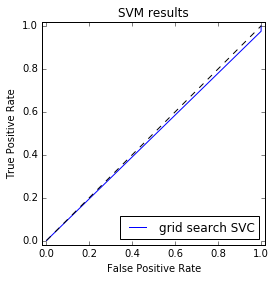

In [237]:
import numpy as np 
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

pipe_svc = Pipeline([
    ( 'scl', StandardScaler() ),
    ( 'clf', SVC() )
])

param_range = [ 0.001, 0.01, 0.1, 1., 10., 100. ]

param_grid = [
    { 
        'clf__C': param_range, 
        'clf__kernel': [ 'linear', 'rbf' ], 
    },
        { 
        'clf__C': param_range, 
        'clf__gamma': param_range, 
        'clf__kernel': [ 'rbf' ], 
    },
]

gs = GridSearchCV( estimator=pipe_svc, param_grid=param_grid, cv=5 ) 

#scores = cross_val_score( gs, X, y, scoring='accuracy', cv=5 )
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

predicted = cross_val_predict( gs, X, y, cv=10 )

fpr, tpr, __ = roc_curve( y, predicted ) 

plt.figure( figsize=(4,4) )
plt.plot( fpr, tpr ) 
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM results')
plt.legend( [ 'grid search SVC' ], loc='lower right' )
plt.show()

In [231]:
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import StratifiedKFold

gs.fit( X, y )
y_pred = gs.predict( X )
confmat = confusion_matrix(y_true=y, y_pred=y_pred)

print(confmat)

[[ 0 10]
 [ 0 40]]


In [233]:
# OK, let's decide on a list of 1000 mutants to model 

len( distance_features )

8880